In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import nibabel as nib
import sys
import os
from time import time, sleep
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append(os.path.dirname('../.'))
from scripts.integral_volume import (Point3d, IntegralVol, IntegralVolTest)
from scripts.niblack3d import Niblack3d
from scripts.multyprocess_utils import MultuProcCalc
from scripts.load_and_save import (get_dcm_info, get_dcm_vol, vox_size2affine,
                                   load_nii_vol, save_vol_as_nii, raw2nifti)
from scripts.utils import print_img, print_imgs
from scripts.hessian_based import frangi_detect, hessian_detect_2016, nn_detect

In [4]:
sample_name= "IXI020"
sample_name = "IXI025-Guys-0852-MRA"
#sample_name = 'test'
path_to_nii_file = f"/home/msst/{sample_name}.nii.gz"

vol_file = nib.load(path_to_nii_file)
brain_vol = np.array(vol_file.dataobj)
print(brain_vol.shape)
print(brain_vol.dtype)

(512, 512, 100)
int16


In [ ]:
frangi_outs = []
sigmas = [2.0, 3.0, 5]#[0.9, 1.6, 2.3, 3.0]
for s in tqdm(sigmas):
    frangi_outs.append(frangi_detect(brain_vol, sigma=s, k=0.5))

  0%|                                                     | 0/3 [00:00<?, ?it/s]

In [ ]:
for idx in range(10, 100, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 1+len(frangi_outs), figsize=(20, 4))    
    print_img(brain_vol, ax[0], slice_=idx, title='brain', cmap='cool')  
    for i, out in enumerate(frangi_outs):
        print_img(out, ax[i+1], slice_=idx, title=f's={sigmas[i]}', cmap='cool')  

In [53]:
frangi_out = np.max(np.array(frangi_outs), axis=0)

In [54]:
path_to_save = f"/home/msst/{sample_name}_frangi.nii.gz"
save_vol_as_nii(frangi_out, vol_file.affine, path_to_save)

path_to_save = f"/home/msst/{sample_name}_frangi_mult.nii.gz"
save_vol_as_nii(brain_vol*frangi_out, vol_file.affine, path_to_save)

In [5]:
hd2016_outs = []
#sigmas = [0.9, 1.6, 2.3, 3.0]
sigmas = [0.9, 2.3]
for s in tqdm(sigmas):
    hd2016_outs.append(hessian_detect_2016(brain_vol, sigma=s, tau=0.5))

  0%|                                                     | 0/2 [00:00<?, ?it/s]/home/msst/repo/MSRepo/VesselSegmentation/research/../scripts/hessian_based.py:46: RuntimeWarning: divide by zero encountered in divide
  out = np.where((l_2 > 0)*(l_rho > 0), (l_2**2) * (l_rho - l_2) * (27.0/((l_2+l_rho)**3)), 0)
/home/msst/repo/MSRepo/VesselSegmentation/research/../scripts/hessian_based.py:46: RuntimeWarning: overflow encountered in divide
  out = np.where((l_2 > 0)*(l_rho > 0), (l_2**2) * (l_rho - l_2) * (27.0/((l_2+l_rho)**3)), 0)
/home/msst/repo/MSRepo/VesselSegmentation/research/../scripts/hessian_based.py:46: RuntimeWarning: invalid value encountered in multiply
  out = np.where((l_2 > 0)*(l_rho > 0), (l_2**2) * (l_rho - l_2) * (27.0/((l_2+l_rho)**3)), 0)
100%|█████████████████████████████████████████████| 2/2 [00:27<00:00, 13.96s/it]


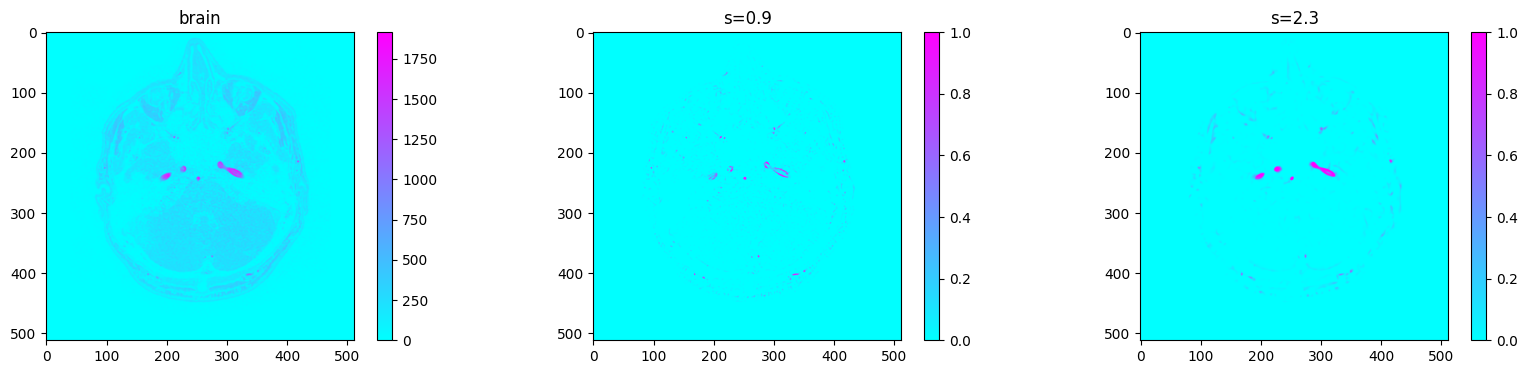

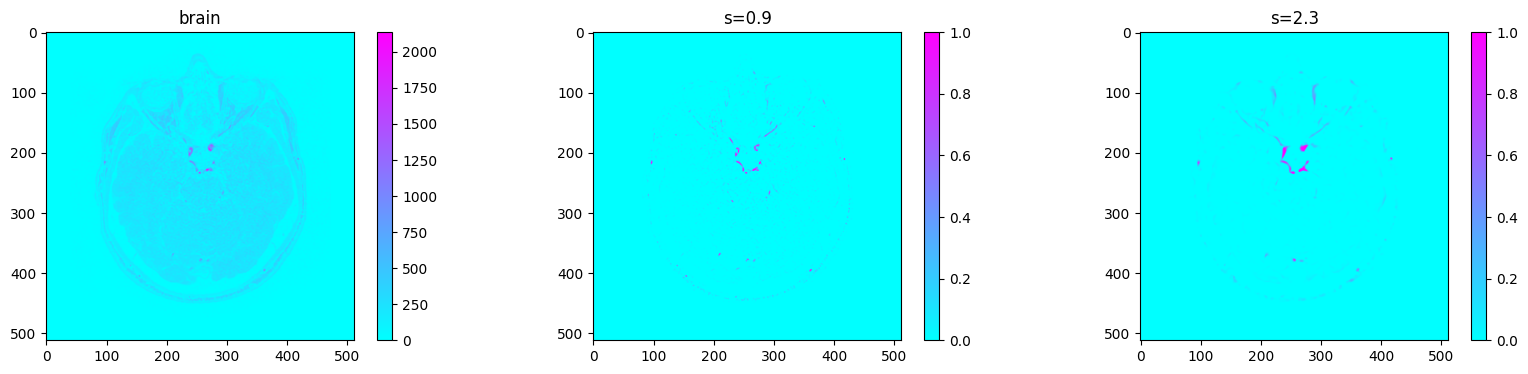

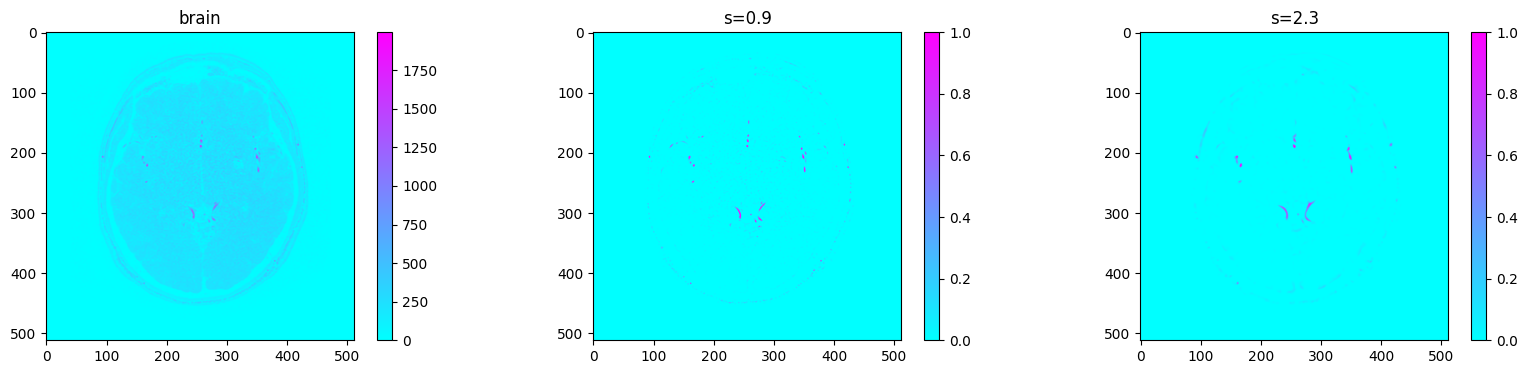

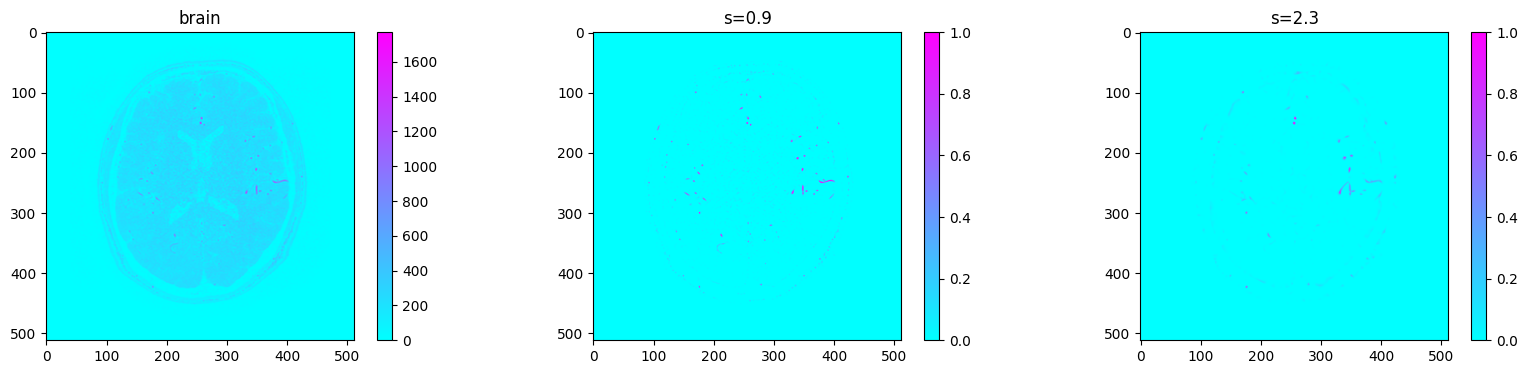

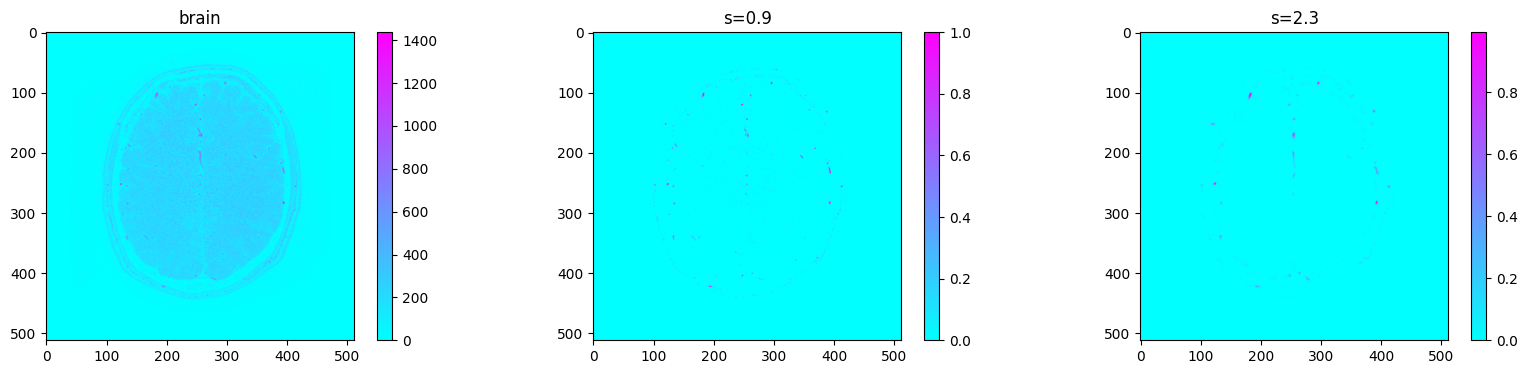

In [6]:
for idx in range(10, 100, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 1+len(hd2016_outs), figsize=(20, 4))    
    print_img(brain_vol, ax[0], slice_=idx, title='brain', cmap='cool')  
    for i, out in enumerate(hd2016_outs):
        print_img(out, ax[i+1], slice_=idx, title=f's={sigmas[i]}', cmap='cool')     

In [7]:
hd2016_out = np.max(np.array(hd2016_outs), axis=0)

In [8]:
path_to_save = f"/home/msst/{sample_name}_hd2016.nii.gz"
save_vol_as_nii(hd2016_out, vol_file.affine, path_to_save)

path_to_save = f"/home/msst/{sample_name}_hd2016_mult.nii.gz"
save_vol_as_nii(brain_vol*hd2016_out, vol_file.affine, path_to_save)

In [512]:
from ml.RAMdataset import generate_patches_pixels

def get_batch_hess(batch, scale):
    N = batch.shape[0]
    out = []
    for i in range(N):
        hes = hessian_matrix(batch[i].squeeze(0).detach().cpu(), scale, use_gaussian_derivatives=False)
        eigvals = hessian_matrix_eigvals(hes)
        out.append(eigvals[np.argsort(np.abs(eigvals[:, 0, 0, 0]), 0)])
    out = torch.tensor(np.array(out))
    return(out)

def get_patch(patch_info, vol, ps): 
    (x, y, z) = (int(patch_info[0]),
                 int(patch_info[1]),
                 int(patch_info[2]))
    patch = torch.tensor(vol[x:x+ps[0],
                             y:y+ps[1],
                             z:z+ps[2]]).unsqueeze(0)
    return(patch)

def make_batches(vol1, vol2, n_patches, patch_size=(64, 64, 64)):
    pp = np.array(generate_patches_pixels(vol1.shape, patch_size, n_patches)).T
    patches1 = torch.zeros(n_patches, 1, *patch_size)
    patches2 = torch.zeros(n_patches, 1, *patch_size)
    for i in range(n_patches):
        patches1[i, 0, :, :, :] = get_patch(pp[i], vol1, patch_size)
        patches2[i, 0, :, :, :] = get_patch(pp[i], vol2, patch_size)
    return(patches1, patches2)

In [520]:
import torch
import torch.nn as nn
from skimage.feature import hessian_matrix, hessian_matrix_eigvals


class HesBlock(nn.Module):
    def __init__(self, scale, patch_size=(64, 64, 64)):
        super(HesBlock, self).__init__()
        
        self.scale = scale
        self.act = nn.Sigmoid()
        self.linear = nn.Sequential(
            nn.Linear(3, 10, bias=True),
            nn.ReLU(),
            #nn.Linear(10, 10, bias=False),
            #nn.PReLU(),
            nn.Linear(10, 1, bias=True)
        )
        self.flat = nn.Flatten(start_dim=1, end_dim=3)
        self.unflat = torch.nn.Unflatten(1, patch_size)
        
    def forward(self, x):
        hes = get_batch_hess(x, 2).permute(0,2,3,4,1)
        x = hes.to("cuda")
        x = self.flat(x)
        x = self.linear(x)
        x = self.unflat(x)
        x = x.permute(0,4,1,2,3)
        x = self.act(x)
        return x

In [534]:
import sys
import os
sys.path.append(os.path.dirname('../ml/metrics'))
from metrics import ExponentialLogarithmicLoss
                     
                     
PATCH_SIZE = (64, 64, 64)
BATCH_SIZE = 16
SCALE = 2

model = HesBlock(scale=SCALE, patch_size=PATCH_SIZE)
loss_fn = ExponentialLogarithmicLoss(gamma_tversky=1, gamma_bce=1, lamb=0.9,
                                                    freq = 0.001, tversky_alfa=0.55)
optim = torch.optim.Adam(model.parameters(), lr=0.05)

In [535]:
vessel_bin_vol = brain_vol*hd2016_out
vessel_bin_vol[vessel_bin_vol<100]=0
vessel_bin_vol[vessel_bin_vol>0]=1

In [536]:
device = "cuda"
model.to(device)

model.train()
for epoch in tqdm(range(100)):
    head_batch, vessel_batch =  make_batches(brain_vol, vessel_bin_vol, BATCH_SIZE, patch_size=PATCH_SIZE)
    head_batch = head_batch.float().to(device)  
    vessel_batch = vessel_batch.float().to(device)  
    
    outputs = model.forward(head_batch)   
    loss = loss_fn(vessel_batch, outputs)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    loss_val = loss.item()
    print(loss_val)
model.eval()
print("done!")

  1%|▍                                          | 1/100 [00:02<03:41,  2.24s/it]

1.5048476457595825


  2%|▊                                          | 2/100 [00:04<03:37,  2.22s/it]

1.2210761308670044


  3%|█▎                                         | 3/100 [00:06<03:35,  2.22s/it]

1.1028574705123901


  4%|█▋                                         | 4/100 [00:08<03:32,  2.21s/it]

1.0212838649749756


  5%|██▏                                        | 5/100 [00:11<03:29,  2.20s/it]

0.9384610652923584


  6%|██▌                                        | 6/100 [00:13<03:26,  2.20s/it]

0.8555197715759277


  7%|███                                        | 7/100 [00:15<03:24,  2.20s/it]

0.784201979637146


  8%|███▍                                       | 8/100 [00:17<03:22,  2.20s/it]

0.7287977337837219


  9%|███▊                                       | 9/100 [00:19<03:18,  2.19s/it]

0.68912672996521


 10%|████▏                                     | 10/100 [00:21<03:16,  2.19s/it]

0.6602075099945068


 11%|████▌                                     | 11/100 [00:24<03:15,  2.20s/it]

0.6337076425552368


 12%|█████                                     | 12/100 [00:26<03:14,  2.21s/it]

0.605667233467102


 13%|█████▍                                    | 13/100 [00:28<03:10,  2.19s/it]

0.578157901763916


 14%|█████▉                                    | 14/100 [00:30<03:08,  2.19s/it]

0.5565799474716187


 15%|██████▎                                   | 15/100 [00:32<03:06,  2.19s/it]

0.5410274863243103


 16%|██████▋                                   | 16/100 [00:35<03:05,  2.20s/it]

0.5248938798904419


 17%|███████▏                                  | 17/100 [00:37<03:02,  2.20s/it]

0.5064482688903809


 18%|███████▌                                  | 18/100 [00:39<03:00,  2.21s/it]

0.48769432306289673


 19%|███████▉                                  | 19/100 [00:41<02:58,  2.20s/it]

0.4705332815647125


 20%|████████▍                                 | 20/100 [00:44<02:56,  2.20s/it]

0.45569267868995667


 21%|████████▊                                 | 21/100 [00:46<02:53,  2.20s/it]

0.4430285692214966


 22%|█████████▏                                | 22/100 [00:48<02:51,  2.20s/it]

0.43211156129837036


 23%|█████████▋                                | 23/100 [00:50<02:48,  2.19s/it]

0.42044734954833984


 24%|██████████                                | 24/100 [00:52<02:47,  2.20s/it]

0.40508508682250977


 25%|██████████▌                               | 25/100 [00:55<02:45,  2.21s/it]

0.3868154287338257


 26%|██████████▉                               | 26/100 [00:57<02:42,  2.20s/it]

0.37046363949775696


 27%|███████████▎                              | 27/100 [00:59<02:40,  2.20s/it]

0.35618335008621216


 28%|███████████▊                              | 28/100 [01:01<02:38,  2.21s/it]

0.3411293029785156


 29%|████████████▏                             | 29/100 [01:03<02:36,  2.21s/it]

0.32893630862236023


 30%|████████████▌                             | 30/100 [01:06<02:34,  2.20s/it]

0.3177323341369629


 31%|█████████████                             | 31/100 [01:08<02:32,  2.20s/it]

0.3065715432167053


 32%|█████████████▍                            | 32/100 [01:10<02:31,  2.22s/it]

0.29957056045532227


 33%|█████████████▊                            | 33/100 [01:12<02:28,  2.22s/it]

0.29784801602363586


 34%|██████████████▎                           | 34/100 [01:14<02:27,  2.23s/it]

0.2905392646789551


 35%|██████████████▋                           | 35/100 [01:17<02:24,  2.23s/it]

0.27949750423431396


 36%|███████████████                           | 36/100 [01:19<02:21,  2.22s/it]

0.27228814363479614


 37%|███████████████▌                          | 37/100 [01:21<02:19,  2.21s/it]

0.2666586935520172


 38%|███████████████▉                          | 38/100 [01:23<02:16,  2.21s/it]

0.2612867057323456


 39%|████████████████▍                         | 39/100 [01:25<02:13,  2.18s/it]

0.2583586871623993


 40%|████████████████▊                         | 40/100 [01:28<02:11,  2.20s/it]

0.2563609778881073


 41%|█████████████████▏                        | 41/100 [01:30<02:11,  2.22s/it]

0.2519127428531647


 42%|█████████████████▋                        | 42/100 [01:32<02:09,  2.24s/it]

0.24653619527816772


 43%|██████████████████                        | 43/100 [01:34<02:08,  2.25s/it]

0.24349021911621094


 44%|██████████████████▍                       | 44/100 [01:37<02:06,  2.26s/it]

0.24260950088500977


 45%|██████████████████▉                       | 45/100 [01:39<02:03,  2.24s/it]

0.240897074341774


 46%|███████████████████▎                      | 46/100 [01:41<02:00,  2.24s/it]

0.23929406702518463


 47%|███████████████████▋                      | 47/100 [01:43<01:58,  2.23s/it]

0.2374047040939331


 48%|████████████████████▏                     | 48/100 [01:46<01:54,  2.21s/it]

0.2346365749835968


 49%|████████████████████▌                     | 49/100 [01:48<01:52,  2.20s/it]

0.2336304485797882


 50%|█████████████████████                     | 50/100 [01:50<01:50,  2.20s/it]

0.23398590087890625


 51%|█████████████████████▍                    | 51/100 [01:52<01:48,  2.20s/it]

0.23346367478370667


 52%|█████████████████████▊                    | 52/100 [01:54<01:46,  2.21s/it]

0.23269830644130707


 53%|██████████████████████▎                   | 53/100 [01:57<01:44,  2.22s/it]

0.23205158114433289


 54%|██████████████████████▋                   | 54/100 [01:59<01:41,  2.21s/it]

0.23110559582710266


 55%|███████████████████████                   | 55/100 [02:01<01:38,  2.20s/it]

0.23055759072303772


 56%|███████████████████████▌                  | 56/100 [02:03<01:36,  2.20s/it]

0.23037171363830566


 57%|███████████████████████▉                  | 57/100 [02:05<01:33,  2.18s/it]

0.2295076549053192


 58%|████████████████████████▎                 | 58/100 [02:08<01:31,  2.19s/it]

0.2283080518245697


 59%|████████████████████████▊                 | 59/100 [02:10<01:29,  2.17s/it]

0.22748081386089325


 60%|█████████████████████████▏                | 60/100 [02:12<01:27,  2.18s/it]

0.22715722024440765


 61%|█████████████████████████▌                | 61/100 [02:14<01:24,  2.16s/it]

0.22701963782310486


 62%|██████████████████████████                | 62/100 [02:16<01:22,  2.16s/it]

0.22659844160079956


 62%|██████████████████████████                | 62/100 [02:17<01:24,  2.22s/it]


KeyboardInterrupt: 

In [546]:
model.to("cpu")
l_func = nn.Sequential(
            model.linear,
            nn.Sigmoid()
)

In [547]:
path_to_nii_file = f"/home/msst/P1_MRA.nii.gz"
test_vol_file = nib.load(path_to_nii_file)
test_vol = np.array(test_vol_file.dataobj)
test_vol.shape

(768, 696, 168)

In [548]:
nn_outs = []
#sigmas = [0.9, 1.6, 2.3, 3.0]
scales = [2]
for s in tqdm(scales):
    nn_outs.append(nn_detect(brain_vol, scale=s, l_func=l_func))

100%|█████████████████████████████████████████████| 5/5 [01:11<00:00, 14.25s/it]


In [ ]:
nn_out = np.max(np.array(nn_out), axis=0)

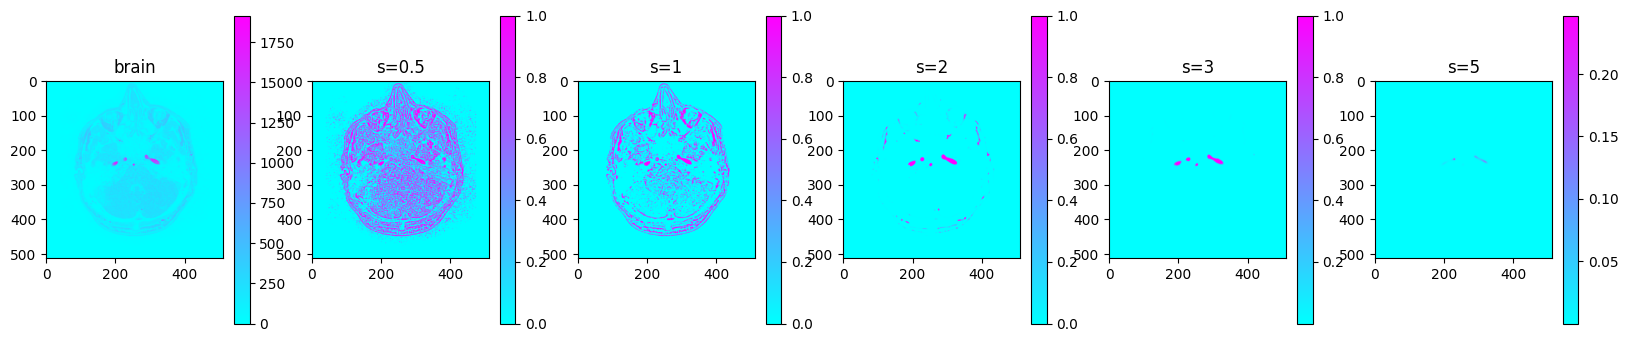

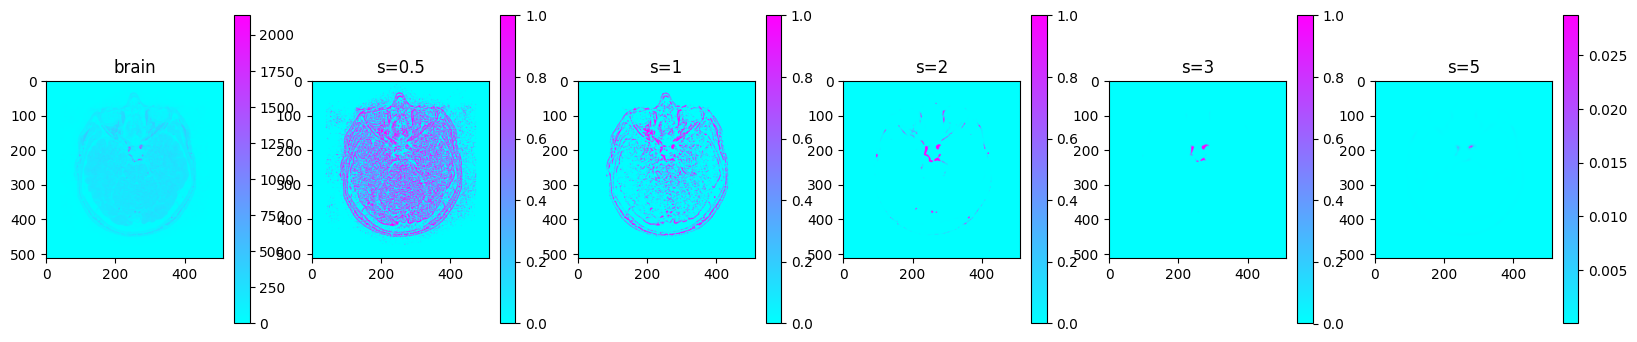

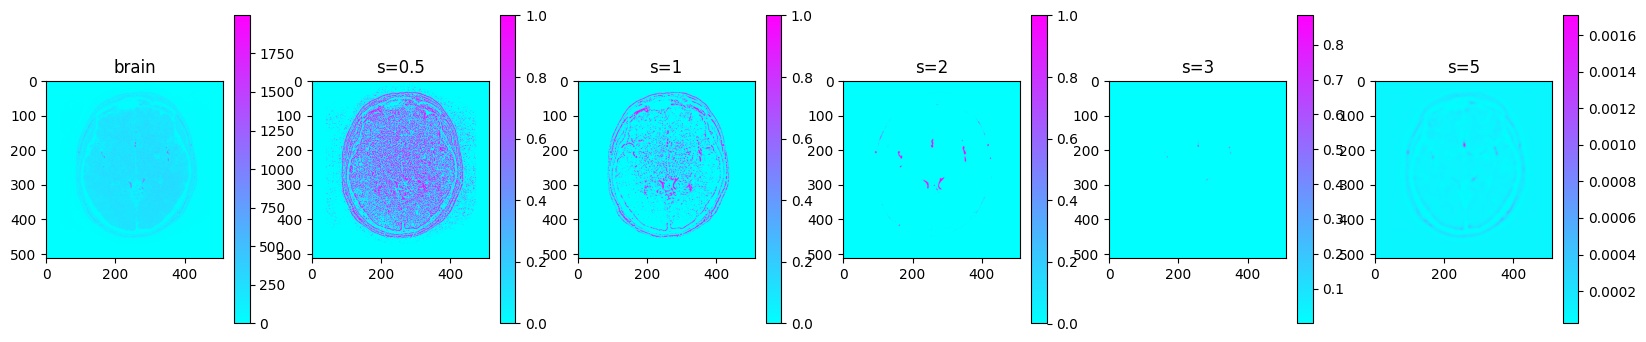

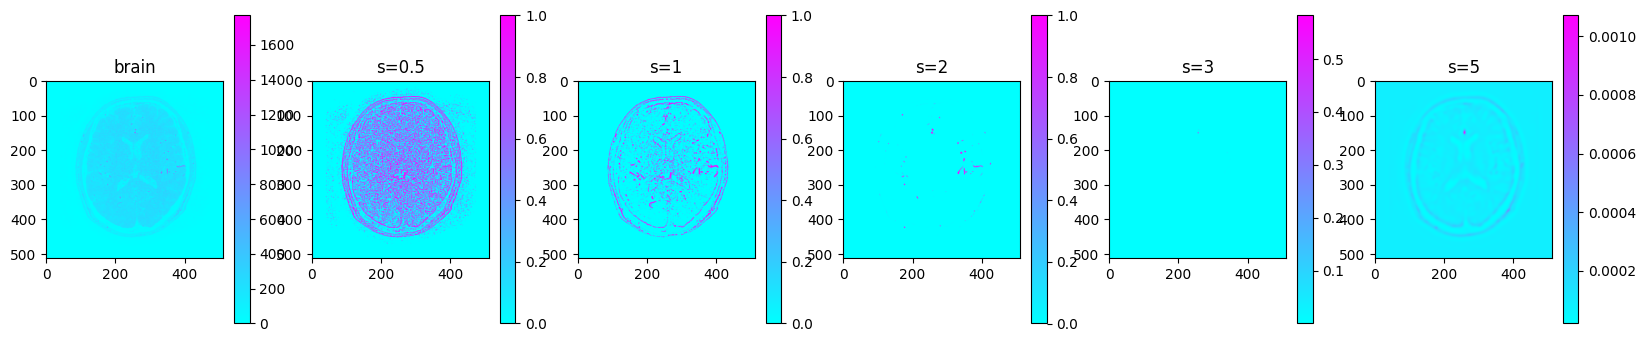

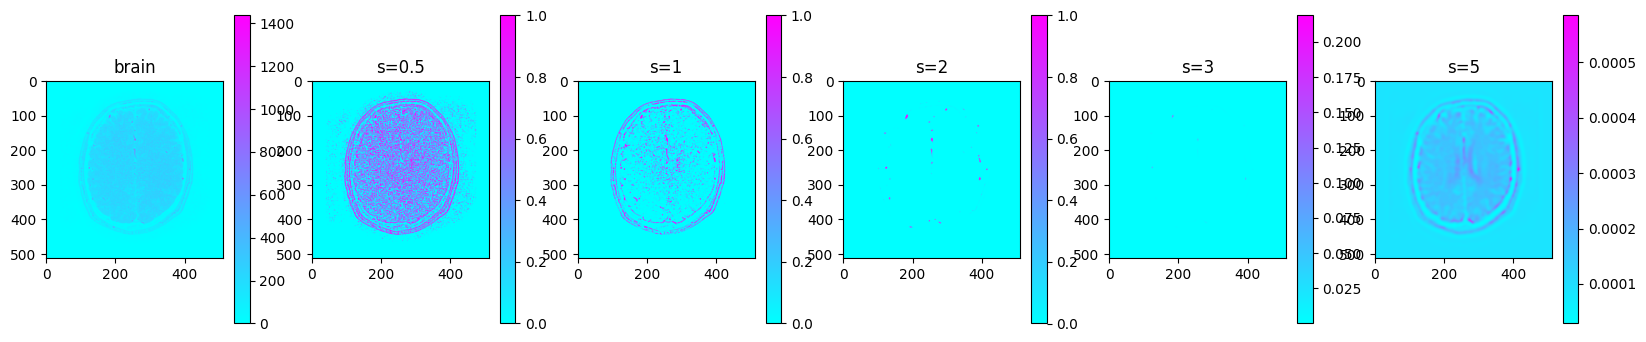

In [550]:
for idx in range(10, 100, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 1+len(nn_outs), figsize=(20, 4))    
    print_img(brain_vol, ax[0], slice_=idx, title='brain', cmap='cool')  
    for i, out in enumerate(nn_outs):
        print_img(out, ax[i+1], slice_=idx, title=f's={scales[i]}', cmap='cool') 

In [ ]:
for idx in range(10, 100, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 3, figsize=(20, 4))    
    print_img(test_vol, ax[0], slice_=idx, title='brain', cmap='hot')  
    print_img(nn_out, ax[2], slice_=idx, title="nn_out", cmap='hot') 

In [545]:
path_to_save = f"/home/msst/P1_MRA_nn.nii.gz"
save_vol_as_nii(nn_out, test_vol_file.affine, path_to_save)